# Approximation of the 1-D Wave Equation With PINNs Using PyTorch

This notebook presents an example of approximating the solution to the 1-D wave equation using phyisics informed neural networks. The equation approximated in this notebook is the one-dimensional wave equation, which is a fundamental equation in physics that describes wave propagation. The equation is given by:
$$
\begin{aligned} \partial_t^2 u(x, t)=c^2 \partial_x^2 u(x, t) & \text { for all } 0<x<1 \text { and } t>0 \\ u(0, t)=u(1, t)=0 & \text { for all } t>0, \\ u(x, 0)=x(1-x) & \text { for all } 0<x<1 \\ \partial_t u(x, 0)=0 & \text { for all } 0<x<1\end{aligned}
$$

In this equation, $u(x, t)$ represents the wave function, which gives the position of the wave at location $x$ and time $t$. The term $c^2$ is the square of the wave speed, and $∂_t^2$ and $∂_x^2$ are the second derivatives with respect to time and space, respectively. 


In the following code block, we import the necessary libraries for our notebook. This includes NumPy for numerical operations, PyTorch for building and training the neural network, Matplotlib for plotting, a utility module for additional plotting functions, and the time module for timing our training process.

In [1]:
# Import NumPy for numerical operations
import numpy as np

# Import PyTorch for building and training neural networks
import torch
import torch.nn as nn
import torch.optim as optim

# Import Matplotlib for plotting
import matplotlib.pyplot as plt

# Import a utility module for additional plotting functions
import utils_plots

# Import the time module to time our training process
import time

# Ignore Warning Messages
import warnings
warnings.filterwarnings("ignore")

In the following code block, we define a function for the analytical solution of the 1D wave equation. We then generate training data in NumPy, create a grid of `x` and `t` values, and calculate the corresponding u values. Finally, we plot the u values as a function of `x` and `t`.

The analytical solution to the wave equation is given by the function:

$$
u(t, x) = \sum_{k=1,...,n} \frac{8}{k^3 \pi^3} \sin(k \pi x) \cos(C k \pi t)
$$

In this equation, `C` is a constant set to 1, `k` is an integer that ranges from 1 to `n`, `x` represents the spatial position, and `t` represents time. The sine and cosine functions create a wave pattern in the `x` and `t` dimensions, respectively. The fraction in front of the sine and cosine functions ensures that the wave pattern diminishes for larger values of `k`.

This function is used to generate the `u` values, which represent the wave's displacement at each point in our grid of `x` (spatial position) and `t` (time) values. This grid forms the basis for our training data, which we will use to train our neural network to approximate the wave equation.

In [2]:
# Define a function for the analytical solution of the 1D wave equation
def analytic_sol_func(t, x):
    c = 1 # wave speed
    return sum([(8 / (k**3 * np.pi**3)) * np.sin(k * np.pi * x) * np.cos(c * k * np.pi * t) for k in range(1, 100, 2)])

# Generate training data in NumPy
x_np = np.linspace(0, 1, 100)  # x data (numpy array), shape=(100,)
t_np = np.linspace(0, 1, 100)  # t data (numpy array), shape=(100,)

# Create a grid of x and t values
x_grid, t_grid = np.meshgrid(x_np, t_np) # x and t data (numpy array), shape=(100, 100)

# Calculate u values using the analytical solution function
u_grid = analytic_sol_func(t_grid,x_grid) # u data (numpy array), shape=(100, 100)

In the following cell, the boundary condition is plotted when $t$=0.

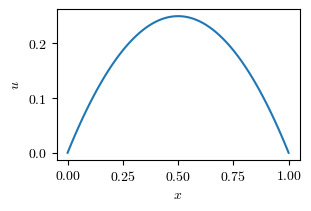

In [3]:
# Create a figure for the plot
fig = plt.figure(figsize=(3.0, 2.0))

plt.plot(x_np,x_np*(1-x_np))

# Set the labels for the x and y axes
plt.xlabel('$x$')
plt.ylabel('$u$')

# Display the plot
plt.show()

In the following code block, we convert our grid data from NumPy arrays to PyTorch tensors, which can be processed more efficiently by our neural network. We also concatenate the spatial (`x`) and temporal (`t`) tensors to form our input data.

In [4]:
# Conversion of the grid data to PyTorch tensors
# Convert x_grid, t_grid, and u_grid to PyTorch tensors
x = torch.from_numpy(x_grid).float().unsqueeze(-1).requires_grad_(True)
t = torch.from_numpy(t_grid).float().unsqueeze(-1).requires_grad_(True)
u = torch.from_numpy(u_grid).float().unsqueeze(-1)

# Concatenation of x and t to form the input data
# Combine x and t tensors to form the input data for the neural network
input_data = torch.cat((x, t), dim=-1)

# Define the boundary conditions for x and t
# Create tensors for x and t at the boundaries
t_boundary = torch.linspace(0,1,100).view(-1,1).requires_grad_(True) # sample locations over the problem domain
x_boundary = torch.linspace(0,1,100).view(-1,1).requires_grad_(True) # sample locations over the problem domain

# Define the boundary conditions
# Create tensors for the boundary conditions at x=0 and x=1 (x_boundary_1 and x_boundary_2)
x_boundary_1 = torch.zeros_like(t_boundary)
x_boundary_2 = torch.ones_like(t_boundary)

# Create tensor for the boundary condition at t=0 (t_boundary_1)
t_boundary_1 = torch.zeros_like(x_boundary).requires_grad_(True)

# Create tensors for the input data at the boundaries
# Combine x_boundary_1 and t_boundary to form the input data at x=0 for all t
input_boundary_x_1 = torch.cat((x_boundary_1, t_boundary), dim=-1)

# Combine x_boundary_2 and t_boundary to form the input data at x=1 for all t
input_boundary_x_2 = torch.cat((x_boundary_2, t_boundary), dim=-1)

# Combine x_boundary and t_boundary_1 to form the input data at t=0 for all x
input_boundary_t_1 = torch.cat((x_boundary, t_boundary_1), dim=-1)

In [5]:
np.shape(t_boundary)

torch.Size([100, 1])

In the following code block, we define our neural network model. This model is a simple feed-forward neural network with **two** hidden layers, each containing **50 neurons**. The activation function used is the hyperbolic tangent (`tanh`). We also instantiate the model, and define the optimizer (**Adam**) and the loss function (**Mean Squared Error**) to be used during training.

In [6]:
# Define a neural network class with three fully connected layers
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(2, 10)
        self.layer2 = nn.Linear(10, 10)
        self.output_layer = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.tanh(self.layer1(x))
        x = torch.tanh(self.layer2(x))
        x = self.output_layer(x)
        return x
    
# Create an instance of the neural network
neural_net = NeuralNetwork()

# Define an optimizer (Adam) for training the network
optimizer = optim.Adam(neural_net.parameters(), lr=0.01)

# Define a loss function (Mean Squared Error) for training the network
loss_func = nn.MSELoss()

In the following code block, we train our neural network. We run the training process for **1000 iterations**, during which we feed the input data to the network, 

In [7]:
# Initialize a list to store the loss values
loss_values = []
c = 1 # wave speed

# Start the timer
start_time = time.time()

# Training the neural network
for i in range(1001):
    # Predictions for boundary conditions
    prediction_boundary_x_1 = neural_net(input_boundary_x_1)
    prediction_boundary_x_2 = neural_net(input_boundary_x_2)
    prediction_boundary_t_1 = neural_net(input_boundary_t_1)
    prediction_boundary_dudt_1 = neural_net(input_boundary_t_1)

    # Compute boundary conditions
    boundary_x_1 = prediction_boundary_x_1 - 0
    boundary_x_2 = prediction_boundary_x_2 - 0
    boundary_t_1 = prediction_boundary_t_1 - x*(1-x)

    # Compute derivative of prediction_boundary_dudt_1 with respect to t_boundary_1
    dudt_boundary_dudt_1  = torch.autograd.grad(prediction_boundary_dudt_1, t_boundary_1, torch.ones_like(prediction_boundary_dudt_1), create_graph=True)[0]

    # Compute loss for boundary conditions
    loss_boundary = torch.mean(boundary_x_1**2) + torch.mean(boundary_x_2**2) + torch.mean(boundary_t_1**2) + torch.mean(dudt_boundary_dudt_1**2)

    # Predictions for physics conditions
    prediction = neural_net(input_data)

    # Compute derivatives of prediction with respect to x and t
    dudx  = torch.autograd.grad(prediction, x, torch.ones_like(prediction), create_graph=True)[0] # computes du/dx
    dudx2 = torch.autograd.grad(dudx,  x, torch.ones_like(dudx),  create_graph=True)[0] # computes d^2u/dx^2
    dudt  = torch.autograd.grad(prediction, t, torch.ones_like(prediction), create_graph=True)[0] # computes du/dt
    dudt2 = torch.autograd.grad(dudt,  t, torch.ones_like(dudt),  create_graph=True)[0] # computes d^2u/dt^2

    # Compute physics condition
    physics = dudt2 - c**2*dudx2

    # Compute loss for physics condition
    loss_physics = torch.mean(physics**2)

    # Total loss is the sum of boundary and physics loss
    loss = loss_boundary + loss_physics

    # Append the current loss value to the list
    loss_values.append(loss.item())

    # Clear gradients for next train
    optimizer.zero_grad()

    # Backpropagation, compute gradients
    loss.backward()

    # Update weights
    optimizer.step()

    # Print loss every 100 iterations
    if i % 100 == 0:
        print(f"Iteration {i}: Loss {loss.item()}")

# Stop the timer and calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# Print training time
print(f"Training time: {elapsed_time} seconds")

# Save a summary of the training process to a text file
with open("summaries/3_Approximation_with_PINNs.txt", "w") as file:
    file.write("Summary of Neural Network Training\n")
    file.write("=================================\n\n")
    file.write(f"Neural Network Architecture:\n{neural_net}\n\n")
    file.write(f"Optimizer Used:\n{type(optimizer).__name__}\n\n")
    file.write(f"Learning Rate:\n{optimizer.param_groups[0]['lr']}\n\n")
    file.write(f"Number of Iterations:\n{len(loss_values)}\n\n")
    file.write(f"Initial Loss:\n{loss_values[0]}\n\n")
    file.write(f"Final Loss:\n{loss_values[-1]}\n\n")
    file.write(f"Training Time:\n{elapsed_time} seconds\n\n")
    
    # Calculate the average loss
    average_loss = sum(loss_values) / len(loss_values)
    file.write(f"Average Loss:\n{average_loss}\n\n")
    
    # Find the iteration with the minimum loss
    min_loss_value = min(loss_values)
    min_loss_iteration = loss_values.index(min_loss_value)
    file.write(f"Minimum Loss:\n{min_loss_value} at iteration {min_loss_iteration}\n\n")

Iteration 0: Loss 0.03923392668366432
Iteration 100: Loss 0.018495675176382065
Iteration 200: Loss 0.003721999004483223
Iteration 300: Loss 0.0005912790074944496
Iteration 400: Loss 0.0004930022405460477
Iteration 500: Loss 0.00047176185762509704
Iteration 600: Loss 0.0010312851518392563
Iteration 700: Loss 0.0002448507002554834
Iteration 800: Loss 0.00022400522721000016
Iteration 900: Loss 0.00023382621293421835
Iteration 1000: Loss 0.00019216966757085174
Training time: 13.009951829910278 seconds


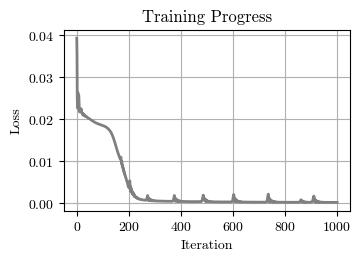

In [8]:
# Create a figure for the plot
fig = plt.figure(figsize=(3.5, 2.5))

# Plot the loss values recorded during training
plt.plot(loss_values, color='gray', linewidth=2)

# Set the labels for the x and y axes
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Set the title for the plot
plt.title('Training Progress')

# Display the grid
plt.grid(True)

# Save the plot as a PNG file in the 'imgs' directory
fig.savefig('imgs/3_Training_Progress_1D_Approximation_with_PINNs.png', format='png')

# Display the plot
plt.show()

In [9]:
# Save the trained model's parameters to a file
torch.save(neural_net.state_dict(), 'models/3_Approximation_with_PINNs.pth')

# Initialize a new instance of the neural network
new_neural_net = NeuralNetwork()

# Load the saved parameters into the new instance of the neural network
new_neural_net.load_state_dict(torch.load('models/3_Approximation_with_PINNs.pth'))

# Ensure the new neural network is in evaluation mode
new_neural_net.eval()

NeuralNetwork(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)

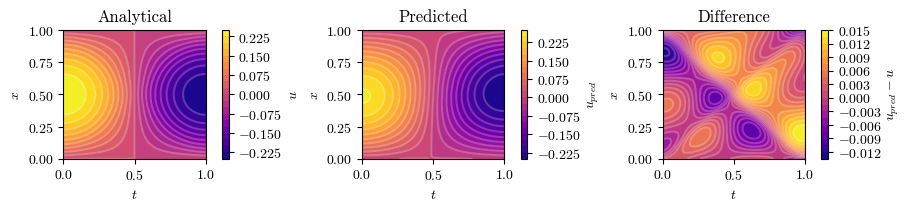

In [10]:
# Generate predictions using the neural network and reshape to match grid
u_pred = neural_net(input_data).detach().numpy().reshape(x_grid.shape)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 2))

# Define a function to plot a contour graph
def plot_contour(ax, x, y, z, title, label):
    im = ax.contourf(x, y, z, origin='lower', levels=20, cmap='plasma')
    ax.set_title(title)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    fig.colorbar(im, ax=ax, label=label)
    ax.contour(x, y, z, levels=20, colors='white', alpha=0.2, linestyles='solid')

# Plot the predicted u values
plot_contour(axs[0], t_grid, x_grid, u_grid, 'Analytical', '$u$')

# Plot the predicted u values
plot_contour(axs[1], t_grid, x_grid, u_pred, 'Predicted', '$u_{pred}$')

# Plot the difference between the predicted and analytical u values
plot_contour(axs[2], t_grid, x_grid, u_pred-u_grid, 'Difference', '$u_{pred}-u$')

# Save the plot as a PDF file in the 'imgs' directory
fig.savefig('imgs/3_Predicted_and_Difference_Approximation_with_PINNs.png', format='png')

# Display the plot
plt.show()

We have approximated a partial differential equation exclusively considering physical loss and boundary losses. In Notebook 2, we focused solely on the loss generated by the data.

Now, we are going to combine both types of losses during training to evaluate the impact on the required time and the achieved accuracy. Therefore, we will repeat the procedure carried out in the previous notebooks, adjusting the cell corresponding to the training.

In [11]:
# Create an instance of the neural network
neural_net = NeuralNetwork()

# Define an optimizer (Adam) for training the network
optimizer = optim.Adam(neural_net.parameters(), lr=0.01)

# Define a loss function (Mean Squared Error) for training the network
loss_func = nn.MSELoss()

In [12]:
# Initialize a list to store the loss values
loss_values = []
c = 1 # wave speed

# Start the timer
start_time = time.time()

# Training the neural network
for i in range(1001):
    # Predictions for boundary conditions
    prediction_boundary_x_1 = neural_net(input_boundary_x_1)
    prediction_boundary_x_2 = neural_net(input_boundary_x_2)
    prediction_boundary_t_1 = neural_net(input_boundary_t_1)
    prediction_boundary_dudt_1 = neural_net(input_boundary_t_1)

    # Compute derivative of prediction_boundary_dudt_1 with respect to t_boundary_1
    dudt_boundary_dudt_1  = torch.autograd.grad(prediction_boundary_dudt_1, t_boundary_1, torch.ones_like(prediction_boundary_dudt_1), create_graph=True)[0]

    # Compute boundary conditions
    boundary_x_1 = prediction_boundary_x_1 - 0
    boundary_x_2 = prediction_boundary_x_2 - 0
    boundary_t_1 = prediction_boundary_t_1 - x*(1-x)

    # Compute loss for boundary conditions
    loss_boundary = torch.mean(boundary_x_1**2) + torch.mean(boundary_x_2**2) + torch.mean(boundary_t_1**2) + torch.mean(dudt_boundary_dudt_1**2)
    
    # Predictions for physics conditions
    prediction = neural_net(input_data)

    # Compute derivatives of prediction with respect to x and t
    dudx  = torch.autograd.grad(prediction, x, torch.ones_like(prediction), create_graph=True)[0] # computes du/dx
    dudx2 = torch.autograd.grad(dudx,  x, torch.ones_like(dudx),  create_graph=True)[0] # computes d^2u/dx^2
    dudt  = torch.autograd.grad(prediction, t, torch.ones_like(prediction), create_graph=True)[0] # computes du/dt
    dudt2 = torch.autograd.grad(dudt,  t, torch.ones_like(dudt),  create_graph=True)[0] # computes d^2u/dt^2

    # Compute physics condition
    physics = dudt2 - c**2*dudx2

    # Compute loss for physics condition
    loss_physics = torch.mean(physics**2)

    # Compute data loss
    data_loss = torch.mean((prediction-u)**2)

    # Total loss is the sum of boundary, physics and data loss
    loss = loss_boundary + loss_physics + data_loss

    # Append the current loss value to the list
    loss_values.append(loss.item())
    
    # Print loss every 1000 iterations
    if i % 100 == 0:
        print(f"Iteration {i}: Loss {loss.item()}")
    
    # Clear gradients for next train
    optimizer.zero_grad()

    # Backpropagation, compute gradients
    loss.backward()

    # Update weights
    optimizer.step()

# Stop the timer and calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

# Save a summary of the training process to a text file
with open("summaries/3_PINNs_including_data_loss.txt", "w") as file:
    file.write("Summary of Neural Network Training\n")
    file.write("=================================\n\n")
    file.write(f"Neural Network Architecture:\n{neural_net}\n\n")
    file.write(f"Optimizer Used:\n{type(optimizer).__name__}\n\n")
    file.write(f"Learning Rate:\n{optimizer.param_groups[0]['lr']}\n\n")
    file.write(f"Number of Iterations:\n{len(loss_values)}\n\n")
    file.write(f"Initial Loss:\n{loss_values[0]}\n\n")
    file.write(f"Final Loss:\n{loss_values[-1]}\n\n")
    file.write(f"Training Time:\n{elapsed_time} seconds\n\n")
    
    # Calculate the average loss
    average_loss = sum(loss_values) / len(loss_values)
    file.write(f"Average Loss:\n{average_loss}\n\n")
    
    # Find the iteration with the minimum loss
    min_loss_value = min(loss_values)
    min_loss_iteration = loss_values.index(min_loss_value)
    file.write(f"Minimum Loss:\n{min_loss_value} at iteration {min_loss_iteration}\n\n")    

Iteration 0: Loss 0.08504495024681091
Iteration 100: Loss 0.027779530733823776
Iteration 200: Loss 0.0016532407607883215
Iteration 300: Loss 0.0005496163503266871
Iteration 400: Loss 0.0003960750182159245
Iteration 500: Loss 0.0002759988128673285
Iteration 600: Loss 0.00023625338508281857
Iteration 700: Loss 0.00026561252889223397
Iteration 800: Loss 0.0001902646035887301
Iteration 900: Loss 0.00022691645426675677
Iteration 1000: Loss 0.00016979061183519661
Training time: 13.283092498779297 seconds


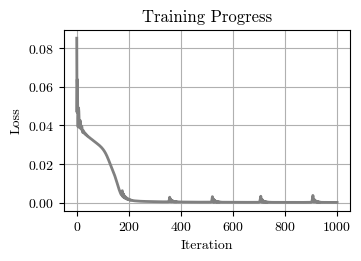

In [13]:
# Create a figure for the plot
fig = plt.figure(figsize=(3.5, 2.5))

# Plot the loss values recorded during training
plt.plot(loss_values, color='gray', linewidth=2)

# Set the labels for the x and y axes
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Set the title for the plot
plt.title('Training Progress')

# Display the grid
plt.grid(True)

# Save the plot as a PNG file in the 'imgs' directory
fig.savefig('imgs/3_Training_Progress_PINNs_including_data_loss.png', format='png')

# Display the plot
plt.show()

In [14]:
# Save the trained model's parameters to a file
torch.save(neural_net.state_dict(), 'models/3_PINNs_including_data_loss.pth')

# Initialize a new instance of the neural network
new_neural_net = NeuralNetwork()

# Load the saved parameters into the new instance of the neural network
new_neural_net.load_state_dict(torch.load('models/3_PINNs_including_data_loss.pth'))

# Ensure the new neural network is in evaluation mode
new_neural_net.eval()

NeuralNetwork(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)

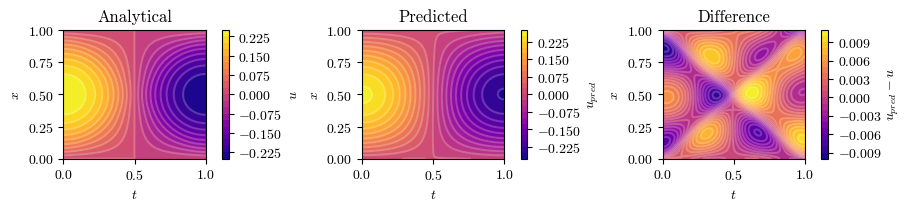

In [15]:
# Generate predictions using the neural network and reshape to match grid
u_pred = neural_net(input_data).detach().numpy().reshape(x_grid.shape)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 2))

# Define a function to plot a contour graph
def plot_contour(ax, x, y, z, title, label):
    im = ax.contourf(x, y, z, origin='lower', levels=20, cmap='plasma')
    ax.set_title(title)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    fig.colorbar(im, ax=ax, label=label)
    ax.contour(x, y, z, levels=20, colors='white', alpha=0.2, linestyles='solid')

# Plot the predicted u values
plot_contour(axs[0], t_grid, x_grid, u_grid, 'Analytical', '$u$')

# Plot the predicted u values
plot_contour(axs[1], t_grid, x_grid, u_pred, 'Predicted', '$u_{pred}$')

# Plot the difference between the predicted and analytical u values
plot_contour(axs[2], t_grid, x_grid, u_pred-u_grid, 'Difference', '$u_{pred}-u$')

# Save the plot as a PDF file in the 'imgs' directory
fig.savefig('imgs/3_Predicted_and_Difference_PINNs_including_data_loss.png', format='png')

# Display the plot
plt.show()

**Summary**

In this notebook, we employed Physics Informed Neural Networks (PINNs) with PyTorch to approximate the solution of the 1-D wave equation. By leveraging both the analytical solution and numerical techniques, we trained a neural network to satisfy the given initial and boundary conditions while minimizing the physics-informed loss function.

- Neural Network Architecture: Two hidden layers with 10 neurons each, employing the hyperbolic tangent activation function.
- Optimizer: Adam optimizer with a learning rate of 0.01.
- Training Iterations: 1000 iterations.
- Loss Function: Mean Squared Error (MSE) for both boundary and physics conditions.